In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.linalg import svd

import torch
import torch.nn.functional as F
from collections import defaultdict

In [3]:
ALPHA = 0.5
coefs_LASSO = pd.read_csv(f'LASSO_coef_alpha_{ALPHA}_NO_PV.csv', header=0, index_col=0)
coefs_LASSO

,Coefficients importance
CNTRYID,1.570051
CNTSCHID,0.000000
CNTSTUID,0.000000
OECD,-3.191918
ADMINMODE,-1.236478
...,...
CREATACT,0.000000
CREATOPN,-1.335293
CREATOR,-0.000000
UNIT,-0.000000


In [4]:
def get_dataset(mode='train', prop=0.5):
    X = pd.read_csv(f'../cleaned_data/X_{mode}.csv', header=0, index_col=0)
    y = pd.read_csv(f'../cleaned_data/y_{mode}.csv', header=None, index_col=None).values.ravel()

    X = X.set_index(["CNTSTUID"])
    X = X.filter(items=coefs_LASSO[coefs_LASSO["Coefficients importance"] != 0].index)
    X = X.drop(columns=X.filter(regex="PV.*").columns)

    df = pd.DataFrame({
        "y": y,
        "CNTSTUID": X.index
    }).set_index("CNTSTUID")

    df = df.merge(X, left_index=True, right_index=True)

    df_drop = (df[df["CNTRYID"].isin([2, 5, 76, 36, 57])].set_index("CNTRYID", append=True).notna().reset_index(level=1).groupby("CNTRYID").sum() == 0).sum(axis=0) > 0
    df_drop = df_drop[df_drop]
    df = df.drop(columns=df_drop.index)
    df = df[df['CNTRYID'].isin({2, 5, 36, 57, 76})]

    encoded_df = pd.get_dummies(df, columns=['CNTRYID'], prefix='CNTRYID', dtype=int)
    A = encoded_df.filter(like='CNTRYID')

    # drop components of A from data
    encoded_df = encoded_df.drop(columns=encoded_df.filter(like='CNTRYID').columns)
    
    X = encoded_df.drop(columns=['y'])
    y = encoded_df['y']

    return X, y, A

def plot_question_hist(X, A):
    fig, ax = plt.subplots(3, sharex=True)
    question = "ST253Q01JA"
    fig.suptitle("How many [digital devices] with screens are there in your [home]?")
    fig.tight_layout()

    X[A["CNTRYID_5"] == 1][question].hist(alpha=0.5, color="green", ax=ax[0])
    X[A["CNTRYID_2"] == 1][question].hist(alpha=0.5, color="blue", ax=ax[0])
    ax[0].set_title('Australia (green), Belgium (blue)')
    X[A["CNTRYID_76"] == 1][question].hist(alpha=0.5, color="black", ax=ax[1])
    ax[1].set_title('United States')
    X[A["CNTRYID_57"] == 1][question].hist(alpha=0.5, color="red", ax=ax[2])
    X[A["CNTRYID_36"] == 1][question].hist(alpha=0.5, color="yellow", ax=ax[2])
    ax[2].set_title('Philippines (red), Jordan (yellow)')

In [5]:
X_train, y_train, A_train = get_dataset(mode='train')
X_train.shape, y_train.shape, A_train.shape

((20563, 348), (20563,), (20563, 5))

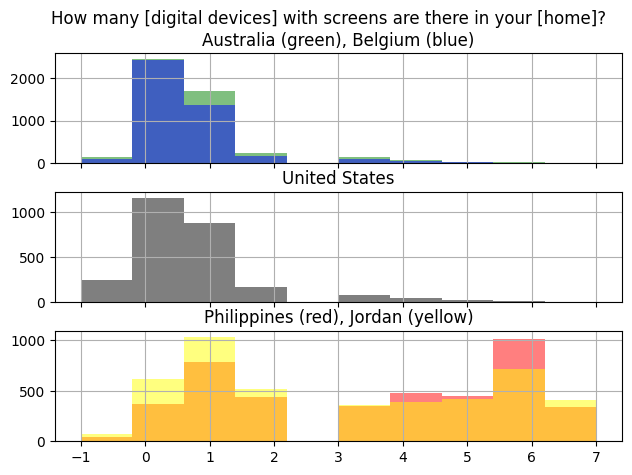

In [6]:
plot_question_hist(X_train, A_train)

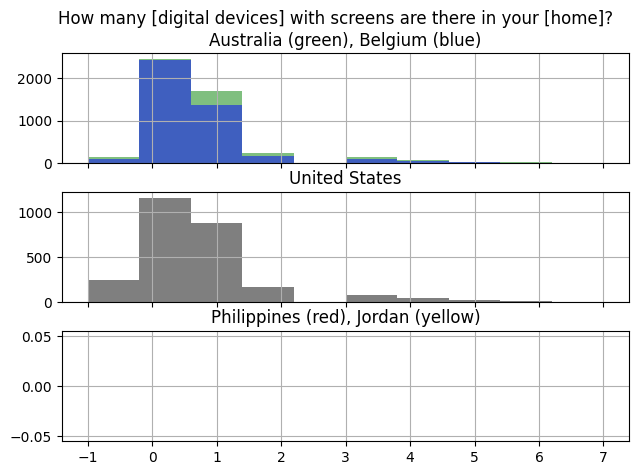

In [7]:
# mask = ((A_train["CNTRYID_57"] == 1) | (A_train["CNTRYID_36"] == 1)) & (X_train[question] < 3)
# mask = ((A_train["CNTRYID_57"] == 1) | (A_train["CNTRYID_36"] == 1)) & (X_train[question] < 6)
mask = ((A_train["CNTRYID_57"] == 1) | (A_train["CNTRYID_36"] == 1))

X_train = X_train[~mask]
y_train = y_train[~mask]
A_train = A_train[~mask]
plot_question_hist(X_train, A_train)

In [8]:
X_test, y_test, A_test = get_dataset(mode='val')
X_test.shape, y_test.shape, A_test.shape

((13539, 348), (13539,), (13539, 5))

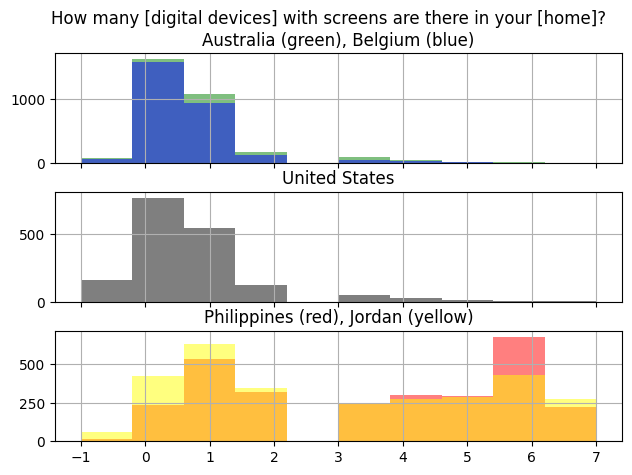

In [9]:
plot_question_hist(X_test, A_test)

In [10]:
A = A_train.to_numpy()
U, s, Vh = svd(A)
rank = np.sum(s > 1e-10)
U_r = U[:, :rank]

A.shape, U_r.shape

((11750, 5), (11750, 3))

In [11]:
# get the projection matrix onto the column-space of A
proj_A = U_r @ U_r.T
proj_A.shape

(11750, 11750)

In [12]:
# Pre-process data
data_processor = Pipeline([
        ('imputer', SimpleImputer(add_indicator=True)), 
        ('scaler', StandardScaler())
    ])
data_processor.fit(X_train)

Pipeline(steps=[('imputer', SimpleImputer(add_indicator=True)),
                ('scaler', StandardScaler())])

In [13]:
X_train_processed = data_processor.transform(X_train)
X_test_processed = data_processor.transform(X_test)

X_train_processed.shape, X_test_processed.shape

((11750, 373), (13539, 373))

In [14]:
# Normalize labels
label_mean = y_train.mean()
label_std = y_train.std()

y_train_normalized = (y_train - label_mean ) / label_std
y_test_normalized = (y_test - label_mean ) / label_std

y_train_normalized.shape, y_test_normalized.shape

((11750,), (13539,))

In [15]:
def unnormalize(x, mean, std):
    return (x*std) + mean

In [16]:
Id = np.eye(proj_A.shape[0])
Id.shape

(11750, 11750)

In [17]:
gammas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 100, 1000, 10000]
mses = {
    'US': [],
    'Australia': [],
    'Belgium': [],
    'Philippines': [],
    'Jordan': []
}
maes = {
    'US': [],
    'Australia': [],
    'Belgium': [],
    'Philippines': [],
    'Jordan': []
}

for gamma in tqdm(gammas):

    y_train_tilde = (Id + (np.sqrt(gamma) - 1)*proj_A) @ y_train_normalized
    X_train_tilde = (Id + (np.sqrt(gamma) - 1)*proj_A) @ X_train_processed

    model = LinearRegression()
    model.fit(X_train_tilde, y_train_tilde)

    y_test_normalized_pred = model.predict(X_test_processed)

    # Get errors for US
    mask = A_test['CNTRYID_76'] == 1
    mses['US'].append(mean_squared_error(y_test_normalized[mask], y_test_normalized_pred[mask]))
    maes['US'].append(mean_absolute_error(y_test_normalized[mask], y_test_normalized_pred[mask]))

    # Get errors for Australia
    mask = A_test['CNTRYID_5'] == 1
    mses['Australia'].append(mean_squared_error(y_test_normalized[mask], y_test_normalized_pred[mask]))
    maes['Australia'].append(mean_absolute_error(y_test_normalized[mask], y_test_normalized_pred[mask]))

    # Get errors for Belgium
    mask = A_test['CNTRYID_2'] == 1
    mses['Belgium'].append(mean_squared_error(y_test_normalized[mask], y_test_normalized_pred[mask]))
    maes['Belgium'].append(mean_absolute_error(y_test_normalized[mask], y_test_normalized_pred[mask]))

    # Get errors for Philippines
    mask = A_test['CNTRYID_57'] == 1
    mses['Philippines'].append(mean_squared_error(y_test_normalized[mask], y_test_normalized_pred[mask]))
    maes['Philippines'].append(mean_absolute_error(y_test_normalized[mask], y_test_normalized_pred[mask]))

    # Get errors for Jordan
    mask = A_test['CNTRYID_36'] == 1
    mses['Jordan'].append(mean_squared_error(y_test_normalized[mask], y_test_normalized_pred[mask]))
    maes['Jordan'].append(mean_absolute_error(y_test_normalized[mask], y_test_normalized_pred[mask]))

100%|██████████| 10/10 [00:51<00:00,  5.17s/it]


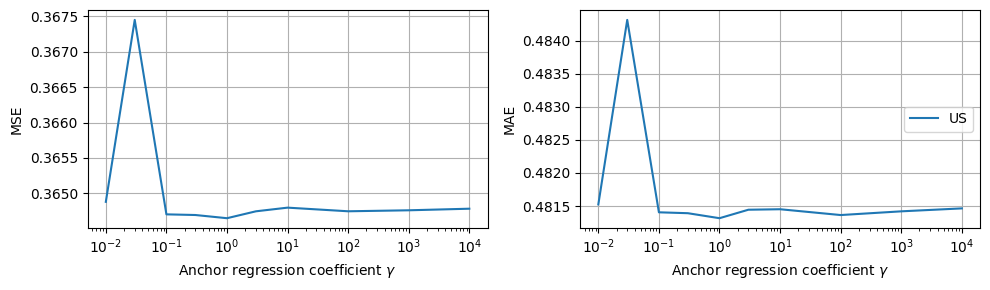

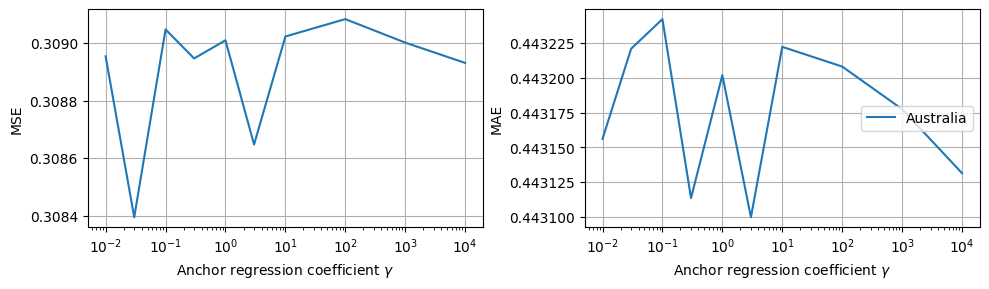

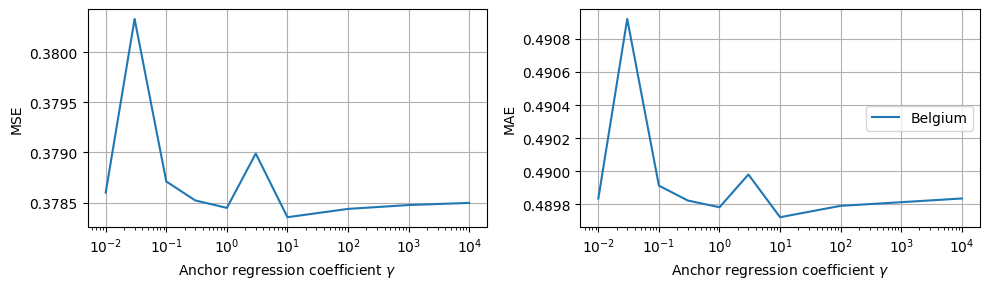

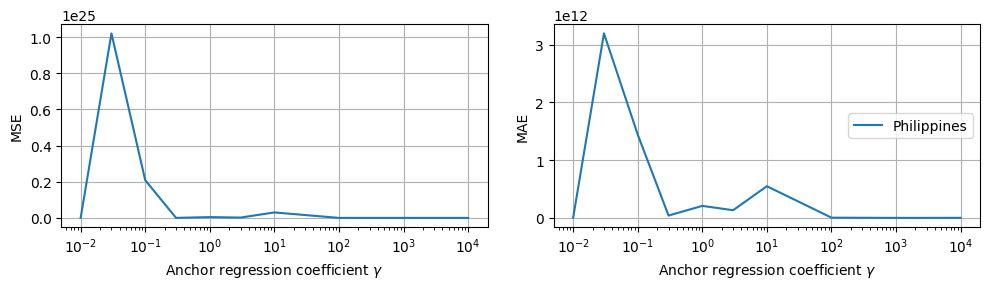

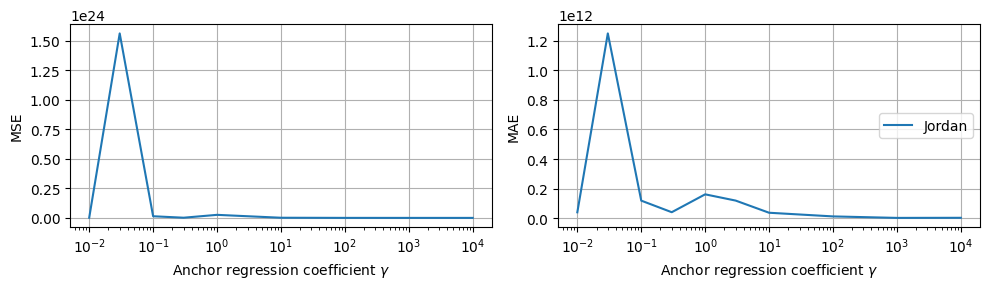

In [18]:
for country in mses:
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    # for country in mses:
    plt.plot(gammas, mses[country], label=country)
    plt.xscale('log')
    plt.grid()
    plt.xlabel(r'Anchor regression coefficient $\gamma$')
    plt.ylabel('MSE')

    plt.subplot(1, 2, 2)
    # for country in maes:
    plt.plot(gammas, maes[country], label=country)
    plt.xscale('log')
    plt.grid()
    plt.xlabel(r'Anchor regression coefficient $\gamma$')
    plt.ylabel('MAE')
    plt.legend(loc='right', bbox_to_anchor=(1.0, 0.5), ncol=1)

    plt.tight_layout()
    plt.show()

In [19]:
mses['Jordan']

[np.float64(1.5357049470553793e+21),
 np.float64(1.5637222773973884e+24),
 np.float64(1.3967881038777532e+22),
 np.float64(1.5819998392758693e+21),
 np.float64(2.5863370988073393e+22),
 np.float64(1.404674894045988e+22),
 np.float64(1.3088819267498413e+21),
 np.float64(1.3012475224018896e+20),
 np.float64(1.7330721175467653e+18),
 np.float64(3.8857430825650125e+18)]